In [1]:
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline
from bassestimate import BassEstimate
from abmdiffuse_sp import Diffuse
from generate_params_boundary_sp import Gen_para
from pymongo import MongoClient
import numpy as np
import pylab as pl
import networkx as nx
import time

In [2]:
client = MongoClient('localhost', 27017)
db = client.abmDiffusion
prj = db.sparcity

## 目标网络

In [3]:
txt_cont = ['gnm_random_graph(10000,1000)', 'gnm_random_graph(10000,2000)',
    'gnm_random_graph(10000,4000)', 'gnm_random_graph(10000,6000)',
    'gnm_random_graph(10000,8000)', 'gnm_random_graph(10000,10000)', 
    'gnm_random_graph(10000,20000)']

g_cont = [eval('nx.' + g) for g in txt_cont]

## 可视化探索

Time elasped:7.89s
网络连边数量:8000
最大采纳量1963, 最大时间步:3
Time elapsed: 0.36s
P:0.0535   Q:0.7732   M:7678
r^2:0.8683


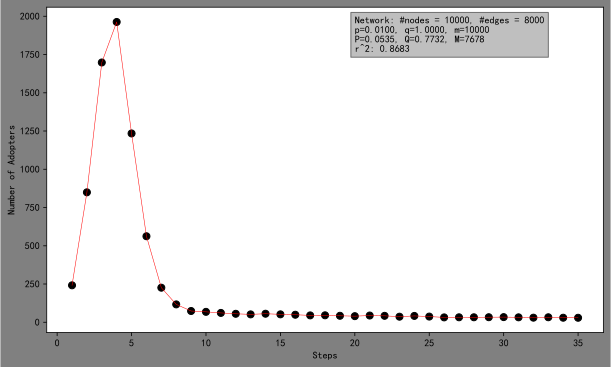

In [12]:
i = 4
g = g_cont[i]
num_edges = g.number_of_edges()

t1 = time.perf_counter()
p, q = 0.01, 1

diff = Diffuse(p, q, g=g)
diff_cont = diff.repete_diffuse()
S = np.mean(diff_cont, axis=0)
print(f"Time elasped:{time.perf_counter()-t1:.2f}s")
print(f"网络连边数量:{num_edges}")
print(f"最大采纳量{np.max(S):.0f}, 最大时间步:{np.argmax(S)}")

m_idx = np.argmax(S)
if m_idx <= 7:
    s = S[:7]
else:
    s = S[:m_idx + 2]
t1 = time.process_time()
para_range = [[1e-5, 0.1], [1e-5, 0.8], [sum(s), 10*sum(s)]]
bassest = BassEstimate(s, para_range)
mse, P, Q, M = bassest.optima_search(c_n=100, threshold=10e-6)
r_2 = bassest.r2([P, Q, M])
print(f'Time elapsed: {(time.process_time() - t1):.2f}s')
print(f'P:{P:.4f}   Q:{Q:.4f}   M:{M:.0f}\nr^2:{r_2:.4f}')

fig = pl.figure(figsize=(10, 6), facecolor='grey')
ax = fig.add_subplot(1, 1, 1)
ax.set_xlabel("Steps")
ax.set_ylabel("Number of Adopters")
ax.plot(np.arange(1, len(S)+1), S, 'r-', lw=0.5)
ax.scatter(np.arange(1, len(S)+1), S, s=50, marker='o', c='k')
text = ax.text(20, np.max(S) * 0.9, f"Network: #nodes = 10000, #edges = {num_edges}\np={p:.4f}, q={q:.4f}, m={nx.number_of_nodes(diff.g)}\nP={P:.4f}, Q={Q:.4f}, M={M:.0f}\nr^2: {r_2:.4f}", 
                bbox=dict(facecolor='grey', alpha=0.5))

## 生成实验参数边界

In [4]:
t1 = time.perf_counter()

p_cont = (0.0001, 0.05)
q_cont = (0.001, 0.5)
delta = (0.001, 0.001)

i = -1
g = g_cont[i]
print(txt_cont[i])
ger_samp = Gen_para(p_cont=p_cont, q_cont=q_cont, g=g, delta=delta)
bound = ger_samp.identify_range()
print(f'time: {time.perf_counter() - t1:.2f}s')
print(bound)

gnm_random_graph(10000,20000)
Exceed the maximal iteration: 100
1 P:0.0162~0.0994 Q:0.0565~0.7969
Exceed the maximal iteration: 100
2 P:0.0087~0.0994 Q:0.0138~0.7969
Exceed the maximal iteration: 100
3 P:0.0081~0.0994 Q:0.0110~0.7969
Exceed the maximal iteration: 100
4 P:0.0234~0.0994 Q:0.0758~0.7969
Exceed the maximal iteration: 100
5 P:0.0025~0.0994 Q:0.0149~0.7969
Exceed the maximal iteration: 100
6 P:0.0099~0.0994 Q:0.0062~0.7969
Exceed the maximal iteration: 100
7 P:0.0484~0.0994 Q:0.0606~0.7969
Exceed the maximal iteration: 100
8 P:0.0056~0.0994 Q:0.0259~0.7969
Exceed the maximal iteration: 100
9 P:0.0089~0.0994 Q:0.0151~0.7969
Exceed the maximal iteration: 100
10 P:0.0015~0.0994 Q:0.0189~0.7969
Exceed the maximal iteration: 100
11 P:0.0248~0.0994 Q:0.0441~0.7969
Exceed the maximal iteration: 100
12 P:0.0017~0.0994 Q:0.0064~0.7969
Exceed the maximal iteration: 100
13 P:0.0041~0.0994 Q:0.0072~0.7969
Exceed the maximal iteration: 100
14 P:0.0316~0.0994 Q:0.0360~0.7969
Exceed the ma

KeyboardInterrupt: 

## 写入参数

In [16]:
bound = {"p_range": [0.001, 0.1], "q_range": [0.01, 0.9]}
for i, txt in enumerate(txt_cont):
    prj.insert_one({"_id": txt_cont[i], "param_boundary": bound})

In [20]:
prj.update_many({}, {"$set": {"state": 0}}, upsert=True)

## 批处理

In [ ]:
for j, txt in enumerate(txt_cont):
    t1 = time.perf_counter()
    print(j + 1, )
    g = g_cont[txt]
    p_cont = (0.0005, 0.03)
    q_cont = (0.08*3, 0.12*3)
    delta = (0.001*5, 0.01*5)
    ger_samp = Gen_para(p_cont=p_cont, q_cont=q_cont, g=g)
    bound = ger_samp.identify_range()
    prj.insert_one({"_id": txt_cont[i], "param_boundary": bound})
    print(f'  time: {time.perf_counter() - t1:.2f}s')

In [5]:
db.list_collection_names()

['abmDatabase',
 'networks',
 'abmEstimate',
 'indivHeter',
 'sparcity',
 'compaAlgorithms',
 'neighEffects',
 'numPoints']

In [6]:
db.networks.find_one({}, projection={"param_boundary": True})

{'_id': 'barabasi_albert_graph(10000,3)',
 'param_boundary': {'p_range': [2.710505431213761e-20, 0.0201],
  'q_range': [0.03, 0.08],
  'P_range': [0.00018951049306492805, 0.031359231900278395],
  'Q_range': [0.09354834836276589, 0.6459727224673583],
  'ctime': datetime.datetime(2018, 12, 15, 14, 53, 10, 938000)}}

In [14]:
prj.find_one({'_id': 'gnm_random_graph(10000,20000)'})

{'_id': 'gnm_random_graph(10000,20000)',
 'param_boundary': {'p_range': [0.001, 0.1], 'q_range': [0.01, 0.9]}}

In [21]:
list(prj.find({}))

[{'_id': 'gnm_random_graph(10000,1000)',
  'param_boundary': {'p_range': [0.001, 0.1], 'q_range': [0.01, 0.9]},
  'state': 0},
 {'_id': 'gnm_random_graph(10000,2000)',
  'param_boundary': {'p_range': [0.001, 0.1], 'q_range': [0.01, 0.9]},
  'state': 0},
 {'_id': 'gnm_random_graph(10000,4000)',
  'param_boundary': {'p_range': [0.001, 0.1], 'q_range': [0.01, 0.9]},
  'state': 0},
 {'_id': 'gnm_random_graph(10000,6000)',
  'param_boundary': {'p_range': [0.001, 0.1], 'q_range': [0.01, 0.9]},
  'state': 0},
 {'_id': 'gnm_random_graph(10000,8000)',
  'param_boundary': {'p_range': [0.001, 0.1], 'q_range': [0.01, 0.9]},
  'state': 0},
 {'_id': 'gnm_random_graph(10000,10000)',
  'param_boundary': {'p_range': [0.001, 0.1], 'q_range': [0.01, 0.9]},
  'state': 0},
 {'_id': 'gnm_random_graph(10000,20000)',
  'param_boundary': {'p_range': [0.001, 0.1], 'q_range': [0.01, 0.9]},
  'state': 0}]